# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 8 de mayo de 2023__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [ ]:
RANDOM_STATE = 1234

# Apartado 1: Análisis de sentimientos con word embeddings


**Número de grupo: 12**

**Nombres de los estudiantes: Greta Angolani y Héloïse Lafargue**

## 1) Carga del conjunto de datos

El fichero `IMBD_Dataset.csv` contiene opiniones de películas clasificadas en 2 categorías diferentes (positiva/negativa).

Este set de datos se creó utilizando el "IMDB Dataset of 50K Movie Reviews", el cual contiene 50,000 reseñas de películas con un sentimiento positivo o negativo adjunto a ellas.

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. Comprueba que la distribución de los ejemplos en las clases es la misma en entrenamiento y test. 

In [ ]:
# acceso a google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
imbd_file = '/content/drive/MyDrive/IA2/p3/IMDB_Dataset.csv'

df=pd.read_csv(imbd_file)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Tenemos que convertir la columna "sentiment" de String a 0/1. Ahora con una variable binaria podemos usar las redes neuronales.

In [ ]:
# Define the mapping from string to binary value
mapping = {'negative': 0, 'positive': 1}

# Replace the strings with their binary values
df.sentiment = df.sentiment.replace(mapping)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


#### a) Ejemplo de cada clase

In [ ]:
# Ejemplo de etiqueta positiva
print("Sentiment ", df.sentiment[20])
print("Review: ", df.review[20])
# Ejemplo de etiqueta negativa
print("Sentiment ", df.sentiment[2000])
print("Review: ", df.review[2000])

Sentiment  1
Review:  After the success of Die Hard and it's sequels it's no surprise really that in the 1990s, a glut of 'Die Hard on a .....' movies cashed in on the wrong guy, wrong place, wrong time concept. That is what they did with Cliffhanger, Die Hard on a mountain just in time to rescue Sly 'Stop or My Mom Will Shoot' Stallone's career.<br /><br />Cliffhanger is one big nit-pickers dream, especially to those who are expert at mountain climbing, base-jumping, aviation, facial expressions, acting skills. All in all it's full of excuses to dismiss the film as one overblown pile of junk. Stallone even managed to get out-acted by a horse! However, if you an forget all the nonsense, it's actually a very lovable and undeniably entertaining romp that delivers as plenty of thrills, and unintentionally, plenty of laughs.<br /><br />You've got to love John Lithgows sneery evilness, his tick every box band of baddies, and best of all, the permanently harassed and hapless 'turncoat' agent

Vemos que hay unos caracteres como "\<br />", las abreviaciones como "s" y "ll" (no el "'t" que es interesante par la negacion) o los numeros que no nos interesan. Asi tendremos que eliminarlos en la normalizacion.

#### b) Estudio del conjunto de datos y normalizacion

Aqui tenemos una descripcion estadistica del conjunto de datos.

In [ ]:
# Descripcion del conjunto de datos 
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,50000.0,0.5,0.500005,0.0,0.0,0.5,1.0,1.0


In [ ]:
#sentimientos count
df.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

Vemos que el conjunto de datos esta balanceado.

Ahora hacemos un estudio del conjunto de datos para ver qué palabras aparecen más veces, y si tendría sentido normalizar de alguna manera el corpus.


In [ ]:
from collections import Counter
max_features = 10000
results = Counter()
df['review'].str.split().apply(results.update)
vocabulary = [key[0] for key in results.most_common(max_features)]

print("Las 100 palabras más comunes son:")
top100 = vocabulary[:100]
print(np.transpose(top100))

Las 100 palabras más comunes son:
['the' 'a' 'and' 'of' 'to' 'is' 'in' 'I' 'that' 'this' 'it' '/><br' 'was'
 'as' 'with' 'for' 'The' 'but' 'on' 'movie' 'are' 'film' 'his' 'have'
 'not' 'you' 'be' 'at' 'by' 'he' 'one' 'an' 'from' 'who' 'like' 'all'
 'they' 'has' 'so' 'just' 'or' 'about' 'her' 'out' 'some' 'very' 'more'
 'This' 'would' 'what' 'when' 'good' 'if' 'their' 'only' 'It' 'really'
 'had' 'up' 'even' "it's" 'can' 'which' 'were' 'see' 'my' 'no' 'than'
 'she' '-' 'there' 'been' 'into' 'get' 'will' 'much' 'story' 'because'
 'other' 'most' 'time' 'we' 'me' 'make' 'do' 'how' 'could' 'also' 'people'
 'its' 'great' '/>The' 'first' 'any' "don't" 'made' 'think' 'bad' 'him'
 'being']


In [ ]:
from collections import Counter
import nltk
nltk.download("punkt")  # Descargar los recursos necesarios para la tokenización

# Contar la frecuencia de las palabras
word_counts = Counter()
for _, row in df.iterrows():
    tokens = nltk.tokenize.word_tokenize(row["review"])  # Tokenizar las palabras
    word_counts.update(tokens)  # Contar la frecuencia de cada palabra

# Crear un DataFrame con las palabras y sus frecuencias
df_word_counts = pd.DataFrame.from_dict(word_counts, orient="index", columns=["frequency"])
df_word_counts.index.name = "word"
df_word_counts.reset_index(inplace=True)

# Ordenar las palabras por frecuencia
df_word_counts.sort_values(by="frequency", ascending=False, inplace=True)

# Imprimir las 12 palabras más comunes
print("Las 12 palabras más comunes son:")
print(df_word_counts.head(20))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Las 12 palabras más comunes son:
     word  frequency
2     the     573398
22      ,     544030
18      .     467982
44    and     309118
56      a     309103
1      of     285087
68     to     263658
25     is     214740
33      /     202455
34      >     202250
31      <     202094
32     br     201948
50     in     173139
130     I     163294
137    it     151931
7    that     137744
263    's     121768
24   this     120442
41    was      99090
35    The      87819


Seria util eliminar los "\<br />", "'s", "'ll" y los términos con solo una letra, la puntuacion y las palabras cortas muy frecuentes sin relacion a los sentimientos que entonces son demasiado frecuentes para estar criterio de pertenencia a una clase o otra.

En las 100 palabras mas frecuentes :
['the' 'a' 'and' 'of' 'to' 'is' 'in' 'I' 'that' 'this' 'it' '/><br' 'was'
 'as' 'with' 'for' 'The' 'but' 'on' 'movie' 'are' 'film' 'his' 'have'
 'not' 'you' 'be' 'at' 'by' 'he' 'one' 'an' 'from' 'who' 'like' 'all'
 'they' 'has' 'so' 'just' 'or' 'about' 'her' 'out' 'some' 'very' 'more'
 'This' 'would' 'what' 'when' 'good' 'if' 'their' 'only' 'It' 'really'
 'had' 'up' 'even' "it's" 'can' 'which' 'were' 'see' 'my' 'no' 'than'
 'she' '-' 'there' 'been' 'into' 'get' 'will' 'much' 'story' 'because'
 'other' 'most' 'time' 'we' 'me' 'make' 'do' 'how' 'could' 'also' 'people'
 'its' 'great' '/>The' 'first' 'any' "don't" 'made' 'think' 'bad' 'him'
 'being']

 solo conservamos las palabras en relacion con las emociones y sentimientos: 'like', 'very', 'more', 'good', 'really','much', 'most', 'great', 'first', 'don't', 'bad'.

Entonces ahora hacemos la normalizacion, asi seria mas facil trabajar con el corpus.

Por eso, realizamos un preprocesamiento simple con la librería nltk que consiste en eliminar estos caracteres especiales y eliminar palabras vacías. No tenemos que pasar a minúsculas porque el CountVectorizer lo hace automaticamente.

In [ ]:
import nltk
import re

wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
#stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    doc = doc.lower()
    doc = re.sub('<br />', ' ', doc) # removing "<br />"
    doc = re.sub(r'\b(\'s|\'ll)', ' ', doc) # removing abreviations
    doc = re.sub(r'\b(the|and|of|to|is|in|i|that|this|it|was|as|with|for|but|on|movie|are|film|his|have|not|you|be|at|by|he)\b', ' ', doc) # removing the useless words
    doc = re.sub(r'\b(one|an|from|who|all|they|has|so|just|or|about|her|out|some|this|would|what|when|if|their|only)\b', ' ', doc) # removing the useless words
    doc = re.sub(r'\b(had|up|even|can|which|were|see|my|no|than|she|there|been|into|get|will|story)\b', ' ', doc) # removing the useless words
    doc = re.sub(r'\b(because|other|time|we|me|make|do|how|could|also|people|its|first|any|made|think|him|being)\b', ' ', doc) # removing the useless words
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) # removing all non-letter characters (excluding spaces)
    doc = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc) # remove all single characters
    doc = re.sub(r'\s+', ' ', doc, flags=re.I) # substituting multiple spaces with single space
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens] #if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
norm_corpus = normalize_corpus(df.review)
norm_corpus

array(['reviewers mentioned after watching oz episode hooked right exactly happened thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison where cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish more scuffles death stares dodgy dealings shady agreements never far away say main appeal show due fact goes where shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around episode ever saw struck nasty surreal couldnt say ready watched more developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order away well mannered middle class inmates turned prison

#### c) Partición de los datos (80-20)

Creamos una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función train_test_split de sklearn. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_corpus, df.sentiment,test_size=0.20, random_state=RANDOM_STATE, stratify=df.sentiment)

In [ ]:
print("Training texts:", len(X_train))
print("Test texts:", len(X_test))
print("Sentimiento: \n", y_train)

Training texts: 40000
Test texts: 10000
Sentimiento: 
 27271    0
15323    0
8206     0
29791    0
22000    0
        ..
41436    1
22461    0
40517    1
25312    0
3799     0
Name: sentiment, Length: 40000, dtype: int64


Y comprobamos que la distribución de los ejemplos en las clases es la misma en entrenamiento y test. 

In [ ]:
# Distribuciones de las clases en entrenamiento y test
train_distribution = pd.Series(y_train).value_counts(normalize=True)
test_distribution = pd.Series(y_test).value_counts(normalize=True)

print("Distribución de etiquetas en el conjunto de entrenamiento:")
print(train_distribution)
print()
print("Distribución de etiquetas en el conjunto de test:")
print(test_distribution)

Distribución de etiquetas en el conjunto de entrenamiento:
0    0.5
1    0.5
Name: sentiment, dtype: float64

Distribución de etiquetas en el conjunto de test:
0    0.5
1    0.5
Name: sentiment, dtype: float64


In [ ]:
df.review = norm_corpus

## 2) Estudio del efecto de distintas configuraciones de word embeddings para resolver la tara

Usa distintas configuraciones de word embeddigns y discute los resultados obtenidos.





Las word-embeddings son representaciones de palabras en espacios de varias dimensiones en los que cada palabra del diccionario es representada mediante un vector de varias dimensiones (decenas o centenas) que permiten capturar su relación con otras palabras.

Existen distintas técnicas para estimar word-embeddings a partir de un corpus de documentos y fijando el número de dimensiones que queremos usar.

El resultado es una matriz de tantas columnas como palabras tenga el diccionario y tantas filas como dimensiones hayamos determinado.

Hay dos formas de obtener las word-embeddings:

- Aprender las word-embeddings  conjuntamente con la tarea principal que le interesa (por ejemplo, clasificación de documentos o predicción de sentimientos). En este caso, empezaría con vectores de palabras aleatorios y aprendería los vectores de palabras del mismo modo que aprende los pesos de una red neuronal.
- Cargar en el modelo las word-embeddings que se calcularon previamente utilizando una tarea de aprendizaje automático distinta de la que intenta resolver. Esto se denomina "word-embeddings preentrenada".

Veamos ambos casos.


### MODELO 1. SIN EMBEDDINGS PRE-ENTRENADOS

El primer modelo consiste en aprender las word-embeddings conjuntamente con la tarea principal de predicción de sentimientos. Empieza con vectores de palabras aleatorios y aprende los vectores de palabras del mismo modo que aprende los pesos de una red neuronal.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

max_words = 1500
max_comment_length = 20

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.review)

sequences = tokenizer.texts_to_sequences(df.review)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_words = len(word_index)

data = pad_sequences(sequences, maxlen=max_comment_length)

Found 135897 unique tokens.


In [ ]:
print(df.review[4])
print(data[4])
print(df.sentiment[4])

petter mattei love money visually stunning watch mr mattei offers us vivid portrait human relations seems telling us money power success different situations encounter variation arthur schnitzler play same theme director transfers action present new york where these different characters meet connect each connected way another next person seems know previous point contact stylishly sophisticated luxurious look taken these live world live own habitat thing gets these souls picture different stages loneliness each inhabits big city exactly best place human relations find sincere fulfillment discerns case most encounter acting good under mr mattei direction steve buscemi rosario dawson carol kane michael imperioli adrian grenier rest talented cast these characters come alive wish mr mattei good luck await anxiously next work
[  10   27    2  393  357  366 1180  395  272  920   93   48   18  126
  996  535  357    2  274   75]
1


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, df.sentiment, test_size=0.20, random_state=RANDOM_STATE, stratify = df.sentiment)

print("Training texts:", len(y_train))
print("Test texts:", len(y_test))

Training texts: 40000
Test texts: 10000


In [ ]:
# Fijamos el tamaño de los embedding a 50 dimensiones

embedding_dim = 50

In [ ]:
# MODELO 1. SIN EMBEDDINGS PRE-ENTRENADOS 

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model1 = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs


model1.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
# After the Embedding layer, our activations have shape `(max_words, max_comment_length, embedding_dim)`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(max_words, max_comment_length * embedding_dim)`
model1.add(Flatten())

# We add the classifier on top
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

history = model1.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test))

score1 = model1.evaluate(x_test, y_test)

print("Accuracy: %.2f%%" % (score1[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            6794850   
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 6,795,851
Trainable params: 6,795,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 124s 98ms/step - loss: 0.4810 - accuracy: 0.7703 - val_loss: 0.4237 - val_accuracy: 0.8046
Epoch 2/20
1250/1250 [==============================] - 119s 95ms/step - loss: 0.3873 - accuracy: 0.8252 - val_loss: 0.4282 - val_accuracy: 0.8022
Epoch 3/20
1250/

Utilizando una capa de embedding directamente obtenemos un 73.23% de accuracy lo que es bastante bien.

### MODELOS 2 & 3. EMBEDDINGS PRE-ENTRENADOS

En lugar de aprender embeddings de palabras conjuntamente con el problema que quiere resolver, podría cargar vectores de embedding de un espacio de embedding precalculado que se sabe que está muy estructurado y que presenta propiedades útiles, que capta aspectos genéricos de la estructura del lenguaje.

Pre-procesar los embeddings:

Vamos a analizar el archivo descomprimido (.txt) para construir un índice de palabras de mapeo (como cadenas) a su representación vectorial (como vectores numéricos).

In [ ]:
import os
import numpy as np

glove_dir = '/content/drive/MyDrive/IA2/p3/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Ahora vamos a construir una matriz de embeddings que podremos cargar en una capa de embedding. Debe ser una matriz de forma (max_words, embedding_dim), donde cada entrada i contiene el vector embedding_dim-dimensional para la palabra de índice i en nuestro índice de palabras de referencia (construido durante la tokenización). Tenemos en cuenta que el índice 0 no se supone que representa ninguna palabra o token - es un marcador de posición.

In [ ]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

#### MODELO 2. EMBEDDINGS PRE-ENTRENADOS CONGELADOS

Definemos el modelo, usando la misma estructura que antes.

In [ ]:
# MODELO 2. EMBEDDINGS PRE-ENTRENADOS CONGELADOS

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 50)            6794850   
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 6,795,851
Trainable params: 6,795,851
Non-trainable params: 0
_________________________________________________________________


Cargamos el GloVe embeddings en el modelo.
La capa de embedding tiene una única matriz de pesos: una matriz flotante 2D en la que cada entrada i es el vector de palabras que debe asociarse al índice i. Carguemos la matriz GloVe que hemos preparado en nuestra capa de embedding, la primera capa de nuestro modelo.

Adicionalmente, congelamos la capa de embedding (establecemos su atributo entrenable en False), entonces una parte de un modelo es pre-entrenada (como nuestra capa de embedding), y otras partes son inicializadas aleatoriamente (como nuestro clasificador), las partes pre-entrenadas no deben ser actualizadas durante el entrenamiento para evitar olvidar lo que ya saben.


In [ ]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

Vamos a compilar nuestro modelo y entrenarlo.

In [ ]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test))

score2 = model2.evaluate(x_test, y_test)

Epoch 1/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6038 - accuracy: 0.6688 - val_loss: 0.5710 - val_accuracy: 0.7009
Epoch 2/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5670 - accuracy: 0.7041 - val_loss: 0.5849 - val_accuracy: 0.6900
Epoch 3/20
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5641 - accuracy: 0.7069 - val_loss: 0.5780 - val_accuracy: 0.6974
Epoch 4/20
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5625 - accuracy: 0.7078 - val_loss: 0.5708 - val_accuracy: 0.7023
Epoch 5/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5610 - accuracy: 0.7103 - val_loss: 0.5803 - val_accuracy: 0.6972
Epoch 6/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5620 - accuracy: 0.7078 - val_loss: 0.5707 - val_accuracy: 0.7044
Epoch 7/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5611 - accuracy: 0.7105 - val_loss: 0.5759 - val_accuracy:

Utilizando este modelo obtenemos un 69.95% de accuracy lo que pudiera mejorarse.

#### MODELO 3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

También podemos intentar entrenar el mismo modelo sin congelar la capa de emebedding. En ese caso, estaríamos adaptando nuestro aprendizaje de emebedding de palabras a una tarea de prediccion de sentimientos.

In [ ]:
# MODELO3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model3.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test))

score3 = model3.evaluate(x_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 50)            6794850   
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 6,795,851
Trainable params: 6,795,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 129s 102ms/step - loss: 0.5441 - accuracy: 0.7162 - val_loss: 0.4598 - val_accuracy: 0.7808
Epoch 2/20
1250/1250 [==============================] - 129s 103ms/step - loss: 0.4214 - accuracy: 0.8041 - val_loss: 0.4342 - val_accuracy: 0.7951
Epoch 3/20
1

Utilizando este modelo obtenemos un 74.01% de accuracy que es el mejor del estudio.

## 3) Análisis final

Analiza con detalle el mejor clasificador. Busca un ejemplo mal clasificado de cada clase, justifica el error ¿se te ocurre alguna forma de solucionarlo?

Compara los resultados obtenidos con y sin word embeddings


#### a) El mejor clasificador: Modelo 3 con word embeddings pre-entrenados sin congelar.

In [ ]:
print("Sin word embeddings pre-entrenados")
print("Accuracy: %.2f%%" % (score1[1]*100))
print("Con word embeddings pre-entrenados congelados")
print("Accuracy: %.2f%%" % (score2[1]*100))
print("Con word embeddings pre-entrenados sin congelar")
print("Accuracy: %.2f%%" % (score3[1]*100))

Sin word embeddings pre-entrenados
Accuracy: 73.23%
Con word embeddings pre-entrenados congelados
Accuracy: 69.95%
Con word embeddings pre-entrenados sin congelar
Accuracy: 74.01%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

classifier= model1
# Prediction
m = 10000
f_x1 = model1.predict(x_test)
predictions1 = np.zeros((m, 1)) 
for i in range (m):
    if f_x1[i] >= 0.5 :
        predictions1[i] = 1
    else :
        predictions1[i] = 0

print(classification_report(y_test, predictions1, target_names=['negative', 'positive']))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

    negative       0.73      0.73      0.73      5000
    positive       0.73      0.73      0.73      5000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

classifier= model2
# Prediction
m = 10000
f_x2 = model2.predict(x_test)
predictions2 = np.zeros((m, 1)) 
for i in range (m):
    if f_x2[i] >= 0.5 :
        predictions2[i] = 1
    else :
        predictions2[i] = 0

print(classification_report(y_test, predictions2, target_names=['negative', 'positive']))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

    negative       0.73      0.63      0.68      5000
    positive       0.68      0.77      0.72      5000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

classifier= model3
# Prediction
m = 10000
f_x = model3.predict(x_test)
predictions3 = np.zeros((m, 1)) 
for i in range (m):
    if f_x[i] >= 0.5 :
        predictions3[i] = 1
    else :
        predictions3[i] = 0

print(classification_report(y_test, predictions3, target_names=['negative', 'positive']))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    negative       0.75      0.72      0.74      5000
    positive       0.73      0.76      0.74      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



Como las clases estaban balanceadas, la accuracy es la métrica pertinente. Y comparando los resultados de accuracy, el mejor clasificador es el modelo 3 con word embeddings pre-entrenados sin congelar.

Averiguamos esta observacion con las matrices de confusion para ver los falsos positivos y los falsos negativos.

Matriz de confusion con el Word-embedding y modelo 1 __________________


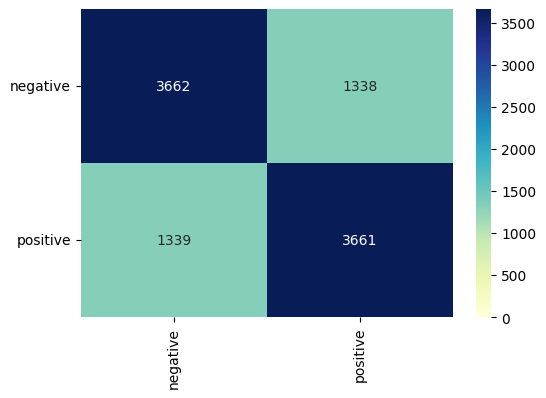

Matriz de confusion con el Word-embedding y modelo 2 __________________


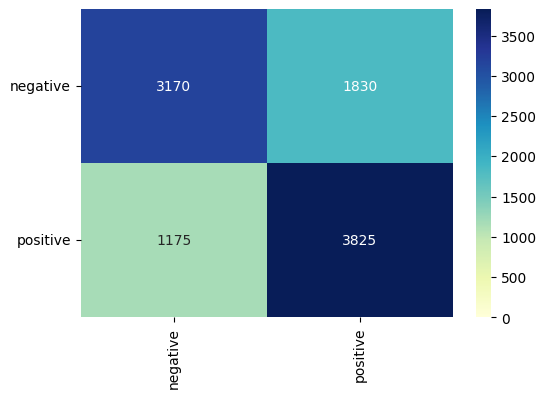

Matriz de confusion con el Word-embedding y modelo 3 __________________


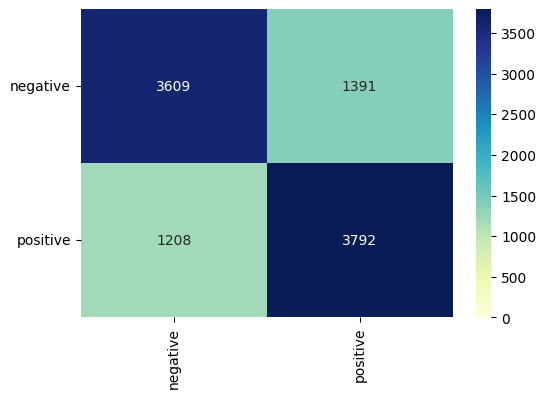

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusion con el Word-embedding y modelo 1 __________________")
conf_matrix = confusion_matrix(y_test, predictions1)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['negative', 'positive'], columns=['negative', 'positive'])

plt.figure(figsize=(6, 4))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

print("Matriz de confusion con el Word-embedding y modelo 2 __________________")
conf_matrix = confusion_matrix(y_test, predictions2)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['negative', 'positive'], columns=['negative', 'positive'])

plt.figure(figsize=(6, 4))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

print("Matriz de confusion con el Word-embedding y modelo 3 __________________")
conf_matrix = confusion_matrix(y_test, predictions3)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['negative', 'positive'], columns=['negative', 'positive'])

plt.figure(figsize=(6, 4))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

#### b) Ejemplo mal clasificado de cada clase

In [ ]:
y = y_test.tolist()

In [ ]:
i = 0
for i in range (len(predictions3)):
  if (y[i] == 1):
    if(predictions3[i] != y[i]):
        print("True sentiment:", y[i], ", Prediction:",predictions3[i],", message n°", i, "\n")
        break
print('Mensaje positivo y predicto negativo _______________')
print(df.review[i])

True sentiment: 1 , Prediction: [0.] , message n° 23 

Mensaje positivo y predicto negativo _______________
let few things straight here am anime fan always matter fact used watch speed racer preschool like several bmovies re hilarious like godzilla movies lot moving comes seems like going your usual down crappy fx sudden boom anime comes goes wwwaaaaayyyyy downhill animation very bad cheap worse remember speed racer crissakes fact cheap few scenes vividly remember bunch kids run school same kids over over again fx terrible too dinosaurs look worse godzilla addition transition live action animation unorganized dialogue voicesespecially english dub viewed horrid begging dad take tape dvd vhs player thing kept surviving cracking jokes comments like robots joelmike mstk pick season honestly way barely enjoy survive same heck planning show another fellow otaku pal mine halloween b night stupid pretty painful watch unintentionally hilarious same giving improvement originally going give acco

El mensaje n°23 es un falso negativo con este clasificador.

In [ ]:
i = 0
for i in range (len(predictions3)):
  if (y[i] == 0):
    if(predictions3[i] != y[i]):
        print("True sentiment:", y[i], ", Prediction:",predictions3[i],", message n°", i, "\n")
        break
print('Mensaje negativo y predicto positivo _______________')
print(df.review[i])

True sentiment: 0 , Prediction: [1.] , message n° 4 

Mensaje negativo y predicto positivo _______________
petter mattei love money visually stunning watch mr mattei offers us vivid portrait human relations seems telling us money power success different situations encounter variation arthur schnitzler play same theme director transfers action present new york where these different characters meet connect each connected way another next person seems know previous point contact stylishly sophisticated luxurious look taken these live world live own habitat thing gets these souls picture different stages loneliness each inhabits big city exactly best place human relations find sincere fulfillment discerns case most encounter acting good under mr mattei direction steve buscemi rosario dawson carol kane michael imperioli adrian grenier rest talented cast these characters come alive wish mr mattei good luck await anxiously next work


El mensaje n°4 es un falso positivo con este clasificador.

#### c) Comparar los resultados obtenidos con y sin word embeddings

Con el clasificador Naive Bayes teniamos una accuracy maxima de 86% mientras con el word embedding tenemos una accuracy maxima de 74%.


Matriz de confusion con el Word-embedding _________________________________________


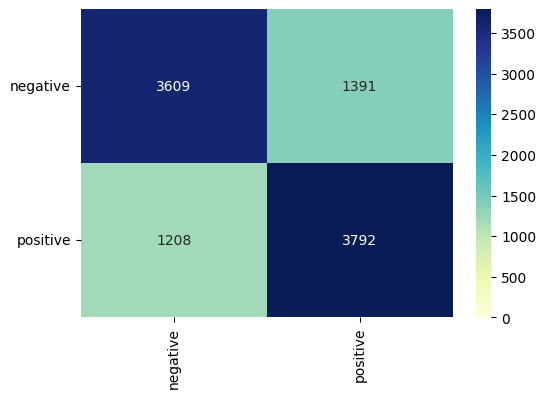

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusion con el Word-embedding _________________________________________")
conf_matrix = confusion_matrix(y_test, predictions3)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['negative', 'positive'], columns=['negative', 'positive'])

plt.figure(figsize=(6, 4))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()


Ademas, con las matrices de confusion en ambos casos, vemos que hay mucho mas falsos positivos y falsos negativos con el word-embedding. Se trata de casi 1000 errores mas en los dos casos de falsa prediccion.

Asi, concluimos que en este caso de prediccion de sentimiento para peliculas, la bolsa de palabras con Naive Bayes es mas eficiente que el word-embedding.


